# BN16

Playground for the bn16 dataset, iterations of cust_embed.

## Imports

In [1]:
#!TMPDIR=../../tmp pip install torch==1.7.* torch-summary numpy pandas matplotlib sparse ipywidgets

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from torchsummary import summary
import sparse
from torch.utils.data import Dataset, DataLoader, random_split
from torch.cuda.amp import autocast

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.pyplot import MaxNLocator
import os
from timeit import default_timer as timer
import datetime
import glob

from ipywidgets import interact, interactive
import ipywidgets

import gc

## Config

In [3]:
DEVICE = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
# DEVICE = torch.device('cuda:1') if torch.cuda.is_available() else torch.device('cpu')
# DEVICE = torch.device('cpu')

print(DEVICE)
RND_SEED = 1
BATCH_SIZE = 64
N_STEPS = 8
N_INDIVIDUALS = 2443

torch.random.manual_seed(RND_SEED)
torch.cuda.manual_seed(RND_SEED)

pd.options.display.max_rows = 20
pd.options.display.min_rows = None
pd.options.display.width = 800
np.set_printoptions(edgeitems=5)
np.core.arrayprint._line_width = 300

cuda


# Data



The data has dimensions $I \times I \times D \times T$, with $I \times I$ being the individuals interactions matrix, $D$ being the day of observation and $T$ being the time of the snapshot (48 times half an hour). The actual dimensions are $2443 \times 2443 \times 56 \times 48$.

That means that we have sequences of length $56 \cdot 48 = 2688$ (in time). The life span of the individuals depends on their tasks and individual factors.

## File Chunking

Transform into daily chunks with dimensions: time x I x I where time is 48x half an hour and I is the individual.

## Additional Data

### Aliveness

In [4]:
observation_start_date = datetime.datetime(2016, 7, 23, 0, 0, 0, 0)
hatching_start_date = datetime.datetime(2016, 7, 19, 0, 0, 0, 0)

In [5]:
indices_data = pd.read_csv('indices_bn16.csv').sort_values(by='bee_id')
alive_data = pd.read_csv('alive_bn16.csv').sort_values(by='bee_id').reset_index(drop=True) # required or the data will be messed up

In [6]:
# combine both
combined_alive_data = alive_data
combined_alive_data['interaction_matrix_idx'] = indices_data['interaction_matrix_idx']
# now sort by matrix id for easy vector generation
combined_alive_data = combined_alive_data.sort_values(by='interaction_matrix_idx')
# date column type fix
combined_alive_data['date_emerged'] = pd.to_datetime(combined_alive_data['date_emerged'])
# let's translate the hatch day into a step where observation_start_date is step 0
combined_alive_data['born_in_step'] = combined_alive_data['date_emerged'].map(lambda x: (x - observation_start_date).days * 48)
combined_alive_data['dead_by_step'] = combined_alive_data.apply(lambda row: 48 * row['days_alive'] + row['born_in_step'], axis=1)
# combined_alive_data = get_combined_alive_data(indices_data, alive_data, observation_start_date)
combined_alive_data

,bee_id,date_emerged,days_alive,interaction_matrix_idx,born_in_step,dead_by_step
0,9,2016-07-19,5,0,-192,48
1,10,2016-07-19,16,1,-192,576
2,17,2016-07-19,4,2,-192,0
3,21,2016-07-19,35,3,-192,1488
4,22,2016-07-19,19,4,-192,720
5,37,2016-07-19,15,5,-192,528
6,38,2016-07-19,8,6,-192,192
7,39,2016-08-01,24,7,432,1584
8,40,2016-07-19,14,8,-192,480
9,43,2016-07-19,18,9,-192,672


For data insights like age distribution take a look at the `insights` notebook.

#### Util

In [7]:
def bee_id_to_matrix_id(bee_id, index_data):
    '''Translates the bee ID into the matrix ID.'''
    return indices_data[indices_data['bee_id'] == bee_id]['interaction_matrix_idx'].item()

def matrix_id_to_bee_id(matrix_id):
    '''Translates the matrix ID into the bee ID.'''
    return indices_data[indices_data['interaction_matrix_idx'] == matrix_id]['bee_id'].item()

def get_aliveness_vector(step):
    '''Returns a #individuals-long boolean vector of matrix-ID-indexed bee aliveness.'''
    return (combined_alive_data['born_in_step'] <= step) & (step < combined_alive_data['dead_by_step'])

def get_lifespan_for_row(row, step):
    if ((step < row['born_in_step']) | (row['dead_by_step'] < step)): #iloc[0] if you pass in a df
        return 0
    return row['dead_by_step'] - step  #iloc[0] if you pass in a df    

def get_lifespan_vector(step):
    '''Returns a #individuals-long vector of matrix-ID-indexed remaining bee lifespans in steps (half an hour).'''
    return combined_alive_data.apply(get_lifespan_for_row, axis=1, step=step)

def get_lifespan_for_individual(midx):
    '''Get the remaining steps to live for given individual matrix index.'''
    # start at zero, not before
    bis = max(combined_alive_data[combined_alive_data['interaction_matrix_idx'] == midx]['born_in_step'].item(), 0)
    dis = combined_alive_data.iloc[midx]['dead_by_step']
    # full range, 56 days à 48 steps
    r = np.zeros(56 * 48) 
    # dead in 4 steps => 4,3,2,1 - clip to length
    ins = np.arange(dis - bis)[::-1][:len(r) - bis] 
    r[bis:bis + len(ins)] = ins
    return r

### Circadian Rhythmicity

In [8]:
circadian_data = pd.read_csv(
    'rhythmicity_bn16.csv',
    dtype={'bee_id': np.int16, 'age': np.int8, 'date': str, 'circadian_rhythmicity': np.float64},
    parse_dates=['date'],
    date_parser = pd.to_datetime
)
circadian_data[0:5]

,bee_id,age,date,circadian_rhythmicity
0,960,7,2016-07-26,0.025426
1,1126,7,2016-07-26,0.022645
2,1519,6,2016-07-26,0.002309
3,1527,7,2016-07-26,0.002183
4,1529,7,2016-07-26,0.009352


In [9]:
# we need to expand the days into 48 copies, also, we don't know if there are gaps in the date so we should not rely on the date to be continous
def circadian_vector_for_individual(bee_id, circadian, observation_start_date):
    '''Get the vector of circadian rhythmicity per step for a bee.
    
    Parameters
    ----------
    bee_id : int
        The ID of the bee.
    circadian : pd.DataFrame
        The data frame with the circadian rhythmicities.
    observation_start_date: datetime
        The datetime of observation start.
    '''
    v = np.zeros(56 * 48)
    for row in circadian[circadian['bee_id'] == bee_id].itertuples():
        ins_start = (row.date - observation_start_date).days * 48
        v[ins_start:ins_start + 48] = np.repeat(row.circadian_rhythmicity, 48)
    return v

## Data Set

In [10]:
class OneDayDataSet(Dataset):
    '''Holds one complete day of the network.'''
    def __init__(self, day, transform=None):
        self.data = sparse.load_npz('daily/{}.npz'.format(day))
        self.transform = transform
        
    def __len__(self):
        return self.data.shape[0]
    
    def __getitem__(self, idx):
        d = torch.from_numpy(self.data[idx].todense())
        if self.transform:
            d = self.transform(d)
        return d

In [11]:
class IndividualDataSet(Dataset):
    '''Holds the data for one individual.'''
    def __init__(self, ind, transform=None):
        self.data = sparse.load_npz('individuals/{}.npz'.format(ind))
        self.transform = transform
        
    def __len__(self):
        return self.data.shape[0]
    
    def __getitem__(self, idx):
        d = torch.from_numpy(self.data[idx].todense())
        if self.transform:
            d = self.transform(d)
        return d

In [12]:
class Bn16DataSet(Dataset):
    def __init__(self, days=(0, 56), transform=None):
        self.days = days
        self.transform = transform
        
    def __len__(self):
        return 2443
    
    def __getitem__(self, idx):        
        d = sparse.load_npz('individuals/{}.npz'.format(idx))
        d = d[self.days[0] * 48:self.days[1] * 48]
        d = torch.from_numpy(d.todense().astype(np.float32))
        if self.transform:
            d = self.transform(d)
        return (
            d,
            {
                'mid': idx,
                'lifespan': get_lifespan_for_individual(idx).astype('float'),
                'circadian': circadian_vector_for_individual(
                    matrix_id_to_bee_id(idx),
                    circadian_data,
                    observation_start_date
                ).astype('float')
            }
        )

In [13]:
class Bn16DataSetDaily(Dataset):
    def __init__(self, days=(0, 56), transform=None):
        self.days = days
        self.transform = transform
        
    def __len__(self):
        return 2443
    
    def __getitem__(self, idx):        
        d = sparse.load_npz('individuals/{}.npz'.format(idx))
        # sum up daily
        d = d.reshape((56, 48, 2443)).sum(axis=1)
        # pick range
        d = d[self.days[0]:self.days[1]]
        d = torch.from_numpy(d.todense().astype(np.float32))
        if self.transform:
            d = self.transform(d)
        return (
            d,
            {
                'mid': idx,
                'lifespan': get_lifespan_for_individual(idx).astype('float'),
                'circadian': circadian_vector_for_individual(
                    matrix_id_to_bee_id(idx),
                    circadian_data,
                    observation_start_date
                ).astype('float')
            }
        )

### Split & Loaders

In [14]:
# first 36 days
bn16_data = Bn16DataSetDaily(days=(0, 35))
len(bn16_data)

2443

In [15]:
# 80/20 split
train_data, test_data = random_split(bn16_data, [1955, 488])

full_loader = DataLoader(
    bn16_data
    ,batch_size=BATCH_SIZE
    ,shuffle=True
    ,num_workers=4
    ,drop_last=True
)
train_loader = DataLoader(
    train_data
    ,batch_size=BATCH_SIZE
    ,shuffle=True
    ,num_workers=4
    ,drop_last=True
)
test_loader = DataLoader(
    test_data
    ,batch_size=BATCH_SIZE
    ,shuffle=True
    ,num_workers=2
    ,drop_last=True
)

In [16]:
for idx, (x, y) in enumerate(train_loader):
    print(idx, x.shape, y)
    break

0 torch.Size([64, 35, 2443]) {'mid': tensor([ 806, 1706, 2093, 1246, 1611,  946, 1691, 1493, 1549, 2199,  996,  245,
        1835, 1281, 1079,  128,  449,  666, 1203,  497,   97, 2225, 1956,  337,
        2288, 1719,  997,  417, 1304, 1475, 1686, 2145, 2012, 1925,   34, 2166,
        1320, 2399,  379, 2089, 1206,  516, 1641,  134, 1447,  716, 1889, 2316,
         367,  130, 1170,  333,  425, 1539, 1218,  279, 1914, 2348, 1190,  792,
        1972,  278,  276,  282]), 'lifespan': tensor([[1775., 1774., 1773.,  ...,    0.,    0.,    0.],
        [   0.,    0.,    0.,  ...,    0.,    0.,    0.],
        [   0.,    0.,    0.,  ...,   98.,   97.,   96.],
        ...,
        [   0.,    0.,    0.,  ...,    0.,    0.,    0.],
        [ 287.,  286.,  285.,  ...,    0.,    0.,    0.],
        [1487., 1486., 1485.,  ...,    0.,    0.,    0.]], dtype=torch.float64), 'circadian': tensor([[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0

In [17]:
len(full_loader), len(train_loader), len(test_loader)

(38, 30, 7)

# Model

In [30]:
class CPC(nn.Module):
    def __init__(self, n_steps, batch_size, hidden_size=256, context_size=256):
        super(CPC, self).__init__()
        self.n_steps = n_steps
        self.hidden_size = hidden_size
        self.context_size = context_size
        self.g_enc = self.encoder()
        self.g_ar = self.autoregressive()
        self.step_W = nn.ModuleList([nn.Linear(self.context_size, self.hidden_size) for i in range(n_steps)])
        self.loss_criterion = nn.CrossEntropyLoss()
        self.batch_size = batch_size
        self.cpc_target = torch.arange(0, batch_size).long().to(DEVICE)
        self.g_enc_hidden = nn.Sequential(
            nn.Conv1d(35, 35, 4, 2, 1, groups=35),
            nn.ConvTranspose1d(35, 35, 4, 2, 1, groups=35)
        )

    def encoder(self):            
        return nn.Parameter(torch.randn(35, 2443, self.hidden_size, device=DEVICE).detach())
        
    def autoregressive(self):
        return nn.GRU(self.hidden_size, self.context_size, batch_first=True)

    def predict(self, x, hidden=None):
        '''Return c_t for the whole given x, all its steps and the hidden state.'''
        with torch.no_grad():
            if hidden == None:
                hidden = self.empty_hidden()
            #z = self.g_enc(x)
            #z = z.squeeze().permute(0, 2, 1)
            x = x.permute((0, 2, 3, 1))
            z = (x * self.g_enc[:, ]).mean(dim=2)
            z = self.g_enc_hidden(z.unsqueeze(1)).squeeze().permute(0,2,1)
            
            pred, hidden = self.g_ar(z, hidden)
            return pred[:,-1,:], pred, hidden

    @autocast()
    def forward(self, x, gar_hidden):
        # put through g_enc
#         print(x.shape) # 8, 1680, 2443
        x = x.permute((0, 2, 3, 1))
#         print(x.shape)
        #z = self.g_enc(x)

        # the embedding of bee i at time t is defined by the learned embeddings of its interactions partners
        # weighted by their interaction strengths with bee i
        z = (x * self.g_enc[:, ]).mean(dim=2)
        z = F.relu(z)
        z = self.g_enc_hidden(z)
        
        # sample a subsequence of n steps
        # but we need at least one bit to feed into the GRU, so we pick from 1 to seqlen - n_steps
        subsample_idx = torch.randint(1, z.shape[1] - self.n_steps, size=(1,)) # 1-1680-12 = 1667
        
        # put everything before our pick through g_ar, collect c_t        
        # g_ar expects shape(batch, seq_len, input_size), h_0 of shape (num_layers * num_directions, batch, hidden_size)
        # https://pytorch.org/docs/master/generated/torch.nn.GRU.html#torch.nn.GRU
        # https://jdhao.github.io/2019/07/10/pytorch_view_reshape_transpose_permute/
#         z = z.squeeze().permute(0, 2, 1)
        c_tx, gar_hidden = self.g_ar(z[:,:subsample_idx,:], gar_hidden) # drop hidden for lstm or add empty init
        c_t = c_tx[:,-1,:].squeeze() # GRU outputs a c for every step - we want the last
        #print(c_tx.shape) # e.g. 8*112*256

        # for n steps, put through W_k for corresponding step to get predictions
        # W_k * c_t
        pred = [self.step_W[step](c_t) for step in range(self.n_steps)]
        #print(pred[0].shape) # 8*512

        # info nce loss
        acc = []
        info_nce_loss = []
        for time_step in range(self.n_steps):
            # f_k = exp(z_{t+k} * W_k * c_t)
            f_k = torch.mm(z[:,subsample_idx + time_step,:].squeeze(), torch.transpose(pred[time_step], 0, 1))
            info_nce_loss.append(self.loss_criterion(f_k, self.cpc_target))
            accuracy = torch.mean((torch.argmax(f_k, dim=1) == self.cpc_target).float())
            acc.append(accuracy)
        info_nce_loss = torch.stack(info_nce_loss).mean()
        
        return torch.mean(info_nce_loss), torch.mean(torch.tensor(acc))
    
    def empty_hidden(self):
        return torch.zeros(1, self.batch_size, self.context_size).to(DEVICE)

In [19]:
# view_model = CPC(N_STEPS, BATCH_SIZE, hidden_size=64, context_size=128).to(DEVICE)
# summary(view_model.g_enc, (1 , 1680, 2443))
# print()
# summary(view_model.g_ar, (1, 64))
# del view_model
# gc.collect()

## Training Code

In [20]:
def train(model, epoch, optimizer, data_loader):
    model.train()
    loss = 0 # epoch loss
    acc = 0  # epoch acc
    epoch_loss = []
    epoch_acc = []
    time_epoch_start = timer()
    report_steps = [.25, .50, .75]
    report_steps.reverse()
    for batch_idx, (x, y) in enumerate(data_loader):
        time_batch_start = timer()
        optimizer.zero_grad()
                
        # add channel dimension - for convolutions
        if len(x.shape) < 4:
            x = x.unsqueeze(1).to(DEVICE)
        
        # fwd - info_nce loss inside forward
        loss, accuracy = model(x, model.empty_hidden())
        
        # back
        loss.backward()
        optimizer.step()

        epoch_loss.append(loss.item())
        epoch_acc.append(accuracy)

        # progress report every couple updates
        if len(report_steps) > 0 and batch_idx / len(data_loader) > report_steps[-1]:
            report_steps.pop()
            print('Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.8f}\tAcc: {:.2f}%\tTime: {:.6f}'.format(
                    epoch,
                    batch_idx * BATCH_SIZE,
                    len(data_loader.dataset),
                    100. * batch_idx / len(data_loader),
                    loss,
                    accuracy * 100,
                    timer() - time_batch_start
                ))

    epoch_loss_mean = torch.mean(torch.tensor(epoch_loss, dtype=torch.float64)).item()
    epoch_acc_mean = torch.mean(torch.tensor(epoch_acc, dtype=torch.float64)).item()
    # epoch report
    print('Epoch: {} [{}/{} (100%)]\tEpoch Loss: {:.8f}\tEpoch Acc: {:.2f}%\tEpoch Time: {:.6f}'.format(
        epoch,
        len(data_loader.dataset),
        len(data_loader.dataset),
        epoch_loss_mean,
        epoch_acc_mean * 100,
        timer() - time_epoch_start
    ))
    return epoch_loss_mean, epoch_acc_mean

-----------

## Downstream Tasks

See https://zenodo.org/record/3862966

Downstream tasks are:

1. Aliveness prediction
2. Circadian rhythmicity
3. Task allocation (via time spent on substrates)

To train the estimator we will choose an index $0 < i <= len_{seq}$ and feed the sequences until this index. The estimator must then predict the remaining life time for the individuals from that index.

In [21]:
def get_temp_y(y, step):
    # 48 steps per day
    return y[:,48 * step]

def train_estimator(cpc_model, downstream_model, downstream_key, optimizer, loss_fn, epoch, data_loader, ctx_size):
    cpc_model.to(DEVICE)
    cpc_model.eval()
    downstream_model.train()

    epoch_loss = []
    epoch_mae = []
    
    for batch_idx, (x, y) in enumerate(data_loader):
        optimizer.zero_grad()

        # add channel dim
        x = x.unsqueeze(1).to(DEVICE)
        y = y[downstream_key]
        y.to(DEVICE)
        #print(x.shape) # 8,1,1680,2443
        
        # cpc output
        output, c, hidden = cpc_model.predict(x)

        # pick an index 0 < i <= len(seq) to feed to the model
        # then diff the lifespan for that index against the prediction
        # TODO: we could use more than one index per batch
        rand_seq_idx = torch.randint(low=1, high=c.shape[1], size=(1,))
        c = c[:,rand_seq_idx].contiguous().view((-1, ctx_size)) # adjust to context size
        #y = y[:,rand_seq_idx]
        y = get_temp_y(y, rand_seq_idx)
                
        # classifier fwd
        c_t = c.to(DEVICE)
        y = y.to(DEVICE)
        output = downstream_model(c_t)

        # loss & backprop
        loss = loss_fn(output.double(), y.double())
        loss.backward()
        optimizer.step()

        # metrics
        epoch_loss.append(loss.item())
        epoch_mae.append(F.l1_loss(output, y, reduction='mean').item())
        
    print('Epoch: {}\tMAE: {:.2f}\tMSE: {:.6f}'.format(epoch, epoch_mae[-1], loss.item()))
        
    return torch.mean(torch.tensor(epoch_loss)), torch.mean(torch.tensor(epoch_mae))

## Aliveness Prediction

The easiest downstream task should be the aliveness prediction. A boolean output answering the question whether an individual is alive or not given a history of interaction matrices might be too easy - if there's some interaction it must be alive, if there is none it might be dead. But predicting how long an individual still has to live is a harder task. Still, if there was no interaction in the recent past the prediction should be zero. But if there was, it's probably hard to predict the future. But how do we deal with the case that the individual was not yet born? Do we output zero? The aliveness ground truth is day-based but our observations are half-hourly. How do we encode this? The value should maybe gradually fade out to zero.

In [22]:
class AlivenessEstimator(nn.Module):
    '''Simple linear regression.'''
    def __init__(self, in_size, out_size):
        super(AlivenessEstimator, self).__init__()
#         self.linear = torch.nn.Linear(in_size, out_size)
        self.linear = nn.Sequential(
            nn.Linear(in_size, 128),
            nn.ReLU(),
            nn.Linear(128, out_size)
        )

    def forward(self, x):
        return self.linear(x)
    
    def predict(self, x):
        return self.linear(x.to(DEVICE))

## Circadian Rhythmicity

The cirdcadian rhythmicity can roughly be described as "wake-sleep cycle" - or better - that cycle is a result of the rhythmicity. Wild et. al tried to fit the activity cycle of the individuals, measured by their velocities withn a timespan, to a sine curve per individual (two parameters: amplitude and phase drift, fixed period of 1/d). They reported the R² values of the fit per individual.

We will try to predict the R² value per individual.

In [23]:
class CircadianEstimator(nn.Module):
    '''Simple linear regression.'''
    def __init__(self, in_size, out_size):
        super(CircadianEstimator, self).__init__()
        self.linear = torch.nn.Linear(in_size, out_size)
#         self.linear = nn.Sequential(
#             torch.nn.Linear(in_size, 256),
#             torch.nn.Linear(256, out_size)
#         )

    def forward(self, x):
        return self.linear(x)
#         return torch.sigmoid(self.linear(x)) # for logistic
    
    def predict(self, x):
        return self.linear(x.to(DEVICE))

## Eval

$R^2 = 1 - \frac{\sum(y - \hat{y})^2}{\sum(y - \bar{y})^2} = 1 - \frac{\sum{y - \hat{y}}^2}{\sum{y^2} - \frac{1}{n} \cdot (\sum{y})^2}$
(Steiner)

In [24]:
def validate(cpc_model, downstream_model, downstream_key, data_loader, ctx_size):
    cpc_model.to(DEVICE)
    cpc_model.eval()
    downstream_model.to(DEVICE)
    downstream_model.eval()

    downstream_mse = []
    downstream_mae = []

#     time_steps_to_check = [1, 100, 200, 500, 1000]
#     time_steps_to_check = [1]
#     time_steps_to_check = range(306)
    time_steps_to_check = range(35)
    
    # for R²
    n = 35 * BATCH_SIZE * len(data_loader) # 35 days á 48 steps x samples per batch x num batches
    sum_of_errors = 0
    y_sum = 0
    y_sq_sum = 0

    for batch_idx, (x, y) in enumerate(data_loader):
        # add channel dim
        x = x.unsqueeze(1).to(DEVICE)
        y = y[downstream_key].to(DEVICE)
        
        inner_mse = []
        inner_mae = []

        # cpc output
        output, c, hidden = cpc_model.predict(x)
        
#         if len(time_steps_to_check) == 1:
#             time_steps_to_check += [int(c.shape[1] / x) for x in [10, 20, 30, 40, 50, 60, 70, 80, 90, 100]]

        for step in time_steps_to_check:
            #c_t = c[:,step].contiguous().view((-1, 256)).to(DEVICE)
            c_t = c[:,step].contiguous().view((-1, ctx_size)).to(DEVICE)
            #y_t = y[:,step].to(DEVICE)
            y_t = get_temp_y(y, step).to(DEVICE)
                
            # classifier fwd
            output = downstream_model.predict(c_t).squeeze()
            
            inner_mse.append(F.mse_loss(output, y_t, reduction='mean'))
            inner_mae.append(F.l1_loss(output, y_t, reduction='mean'))
            # for R²
            sum_of_errors += torch.sum(torch.pow(y_t - output, 2)).item()
            y_sum += torch.sum(y_t).item()
            y_sq_sum += torch.sum(torch.pow(y_t, 2)).item()

        downstream_mse.append(torch.mean(torch.tensor(inner_mse, dtype=torch.float64)))
        downstream_mae.append(torch.mean(torch.tensor(inner_mae, dtype=torch.float64)))

    r2 = 0
    try:
        r2 = 1 - sum_of_errors / (y_sq_sum - (y_sum ** 2) / n)
    except:
        pass
    
    # MSE, MAE, R²
    return (
        torch.mean(torch.tensor(downstream_mse, dtype=torch.float64)).item(), 
        torch.mean(torch.tensor(downstream_mae, dtype=torch.float64)).item(),
        r2
    )

## Saving & Loading

Code for saving & loading checkpoints.

In [25]:
CHECKPOINT_PATH = './checkpoints/'
CHECKPOINT_PATH_DOWNSTREAM = './checkpoints/ds/'

In [26]:
def save_model(model, optimizer, loss_hist, metrics, checkpoint_path, device=DEVICE):
    '''Save the a given model's parameters, optimizer, loss and metrics[] history.'''
    # in case there are some tensors map everything to plain numbers
    loss = list(map(lambda x: x.item() if isinstance(x, torch.Tensor) else x, loss_hist))
    for i in range(len(metrics)):
        metrics[i] = list(map(lambda x: x.item() if isinstance(x, torch.Tensor) else x, metrics[i]))
    
    # move to CPU for saving
    model.cpu() 
    checkpoint = {
        'params': model.state_dict(),
        'optimizer': optimizer.state_dict(),
        'loss': loss,
        'metrics': metrics,
        'schema_version': 1
    }
    torch.save(checkpoint, checkpoint_path)
    # move back to target device
    model.to(device)
    
def load_model(model, optimizer, checkpoint_path, device=DEVICE):
    '''Load a model's parameters, optimizer, loss and metrics[] history.'''
    checkpoint = torch.load(checkpoint_path)

    model.load_state_dict(checkpoint['params'])
    model.to(device)

    optimizer.load_state_dict(checkpoint['optimizer'])
    loss = checkpoint['loss']
    metrics = checkpoint['metrics']
    try:
        schema_version = checkpoint['schema_version']
    except KeyError:
        schema_version = 1
    return {
        'model': model,
        'optimizer': optimizer,
        'loss': loss,
        'metrics': metrics,
        'schema_version': schema_version
    }

def list_models():
    return glob.glob('./checkpoints/*'), glob.glob('./checkpoints/ds/*')

In [27]:
list_models()

(['./checkpoints/cpc_checkpoint_nbh.pt',
  './checkpoints/cpc_checkpoint_32_64_500epochs.pt',
  './checkpoints/cpc_checkpoint_nbh_64_128.pt',
  './checkpoints/cpc_checkpoint_wide_cnn.pt',
  './checkpoints/cpc_checkpoint_cembed_b64_h64',
  './checkpoints/cpc_checkpoint_32_64.pt',
  './checkpoints/cpc_checkpoint_pos512.pt',
  './checkpoints/cpc_checkpoint_spatio_temp.pt',
  './checkpoints/cpc_checkpoint_temp_stacked.pt',
  './checkpoints/ds',
  './checkpoints/cpc_checkpoint_hyperopt',
  './checkpoints/cpc_checkpoint_cembed',
  './checkpoints/cpc_checkpoint_hyperopt_lstm.pt',
  './checkpoints/cpc_checkpoint_spatio_temp_fw.pt'],
 ['./checkpoints/ds/ds_checkpoint_pos512.pt',
  './checkpoints/ds/ds_checkpoint_alive_cembed',
  './checkpoints/ds/ds_checkpoint_alive_cembedxl_sl1',
  './checkpoints/ds/ds_circadian_pos_64_128.pt',
  './checkpoints/ds/ds_checkpoint.pt',
  './checkpoints/ds/ds_checkpoint_circadian_cembedxl',
  './checkpoints/ds/ds_checkpoint_alive_64_128.pt',
  './checkpoints/ds/ds

# Training

## Training - CPC

Actual training of the CPC model.

In [31]:
# full day
model = CPC(N_STEPS, BATCH_SIZE, hidden_size=64, context_size=64).to(DEVICE)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001, betas=(0.9, 0.999), eps=1e-08, weight_decay=0)

In [32]:
loss_cpc = []
acc_cpc = []
checkpoint_name = 'cpc_checkpoint_cembed_b64_h64_stck'

In [33]:
if False: # switch to True to load
# if True:
    loaded_state = load_model(model, optimizer, CHECKPOINT_PATH + checkpoint_name)
    loss_cpc = loaded_state['loss']
    acc_cpc = loaded_state['metrics'][0]
    del loaded_state

In [46]:
for epoch in range(10):
    l, a = train(model, epoch, optimizer, full_loader) # train_loader
    loss_cpc.append(l)
    acc_cpc.append(a)

Epoch: 0 [640/2443 (26%)]	Loss: 1.30488515	Acc: 50.00%	Time: 0.046508
Epoch: 0 [1280/2443 (53%)]	Loss: 1.55640841	Acc: 43.55%	Time: 0.046296
Epoch: 0 [1856/2443 (76%)]	Loss: 1.69171834	Acc: 33.98%	Time: 0.045550
Epoch: 0 [2443/2443 (100%)]	Epoch Loss: 1.60076269	Epoch Acc: 41.20%	Epoch Time: 19.667796
Epoch: 1 [640/2443 (26%)]	Loss: 1.69215810	Acc: 38.28%	Time: 0.046688
Epoch: 1 [1280/2443 (53%)]	Loss: 1.89611876	Acc: 31.25%	Time: 0.045265
Epoch: 1 [1856/2443 (76%)]	Loss: 2.03392267	Acc: 29.88%	Time: 0.045023
Epoch: 1 [2443/2443 (100%)]	Epoch Loss: 1.55384638	Epoch Acc: 42.73%	Epoch Time: 19.368910
Epoch: 2 [640/2443 (26%)]	Loss: 1.68347239	Acc: 37.89%	Time: 0.045226
Epoch: 2 [1280/2443 (53%)]	Loss: 1.46935439	Acc: 45.12%	Time: 0.045888
Epoch: 2 [1856/2443 (76%)]	Loss: 1.45683277	Acc: 42.58%	Time: 0.045814
Epoch: 2 [2443/2443 (100%)]	Epoch Loss: 1.51489920	Epoch Acc: 42.96%	Epoch Time: 19.621145
Epoch: 3 [640/2443 (26%)]	Loss: 1.41960621	Acc: 45.31%	Time: 0.045797
Epoch: 3 [1280/2443 (

(1.5804640148815357, 0.41586143092105265)

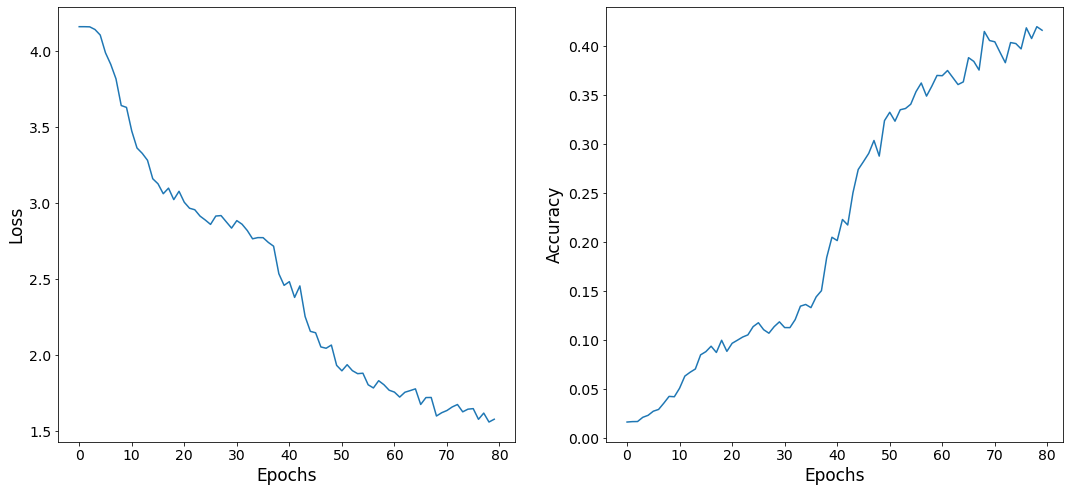

In [45]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 8))
ax1.plot(np.arange(len(loss_cpc)), loss_cpc)
ax1.set_xlabel('Epochs', fontsize=17)
ax1.set_ylabel('Loss', fontsize=17)
ax1.tick_params(axis='both', which='major', labelsize=14)
ax2.plot(np.arange(len(acc_cpc)), acc_cpc)
ax2.set_xlabel('Epochs', fontsize=17)
ax2.set_ylabel('Accuracy', fontsize=17)
ax2.tick_params(axis='both', which='major', labelsize=14)
#fig.suptitle('CPC training metrics', fontsize=16)
loss_cpc[-1], acc_cpc[-1]

In [265]:
# save_model(model, optimizer, loss_cpc, [acc_cpc], CHECKPOINT_PATH + checkpoint_name) # .8060

## Training - Downstream

Actual training of the downstream model(s).

### Aliveness

In [148]:
downstream_model = AlivenessEstimator(64, 1).to(DEVICE)
downstream_optimizer = torch.optim.Adam(downstream_model.parameters())
downstream_loss = nn.MSELoss()
# downstream_loss = nn.SmoothL1Loss()
# downstream_loss = nn.L1Loss()

# class R2Loss(nn.Module):
#     def forward(self, y_pred, y):
#         variance = torch.var(y, unbiased=False)
#         return 1. - F.mse_loss(y_pred, y, reduction="mean") / variance
# downstream_loss = R2Loss()

In [149]:
loss_hist_downstream = []
second_metric_hist_downstream = []

downstream_val_mse = []
downstream_val_mae = []
downstream_val_r2 = []
best = 99999999999999
checkpoint_name = 'ds_checkpoint_alive_cembedxl_h128'

In [150]:
if False: # switch to True to load
# if True:
    loaded_state = load_model(downstream_model, downstream_optimizer, CHECKPOINT_PATH_DOWNSTREAM + checkpoint_name)
    loss_hist_downstream = loaded_state['loss']
    second_metric_hist_downstream = loaded_state['metrics'][0]
    best = loaded_state['metrics'][1][0]
    downstream_val_mse = loaded_state['metrics'][2]
    downstream_val_mae = loaded_state['metrics'][3]
    downstream_val_r2 = loaded_state['metrics'][4]
    del loaded_state

In [162]:
for epoch in range(1):
    l, a = train_estimator(model, downstream_model, 'lifespan', downstream_optimizer, downstream_loss, epoch, train_loader, 64)
    loss_hist_downstream.append(l)
    second_metric_hist_downstream.append(a)
    
    mse, mae, r2 = validate(model, downstream_model, 'lifespan', test_loader, 64)
    downstream_val_mse.append(mse)
    downstream_val_mae.append(mae)
    downstream_val_r2.append(r2)
    print('val: \tMAE: {:.2f}\tMSE: {:.6f}\tR2: {:.6f}'.format(mae, mse, r2))
    
    # checkpoint
    if mse < best:
        best = mse
        save_model(downstream_model, downstream_optimizer, loss_hist_downstream, 
                   [second_metric_hist_downstream, [best], downstream_val_mse, downstream_val_mae, downstream_val_r2],
                   CHECKPOINT_PATH_DOWNSTREAM + checkpoint_name)
        print('checkpointed')

Epoch: 0	MAE: 208.33	MSE: 80720.343660
val: 	MAE: 254.37	MSE: 143093.075267	R2: 0.278251


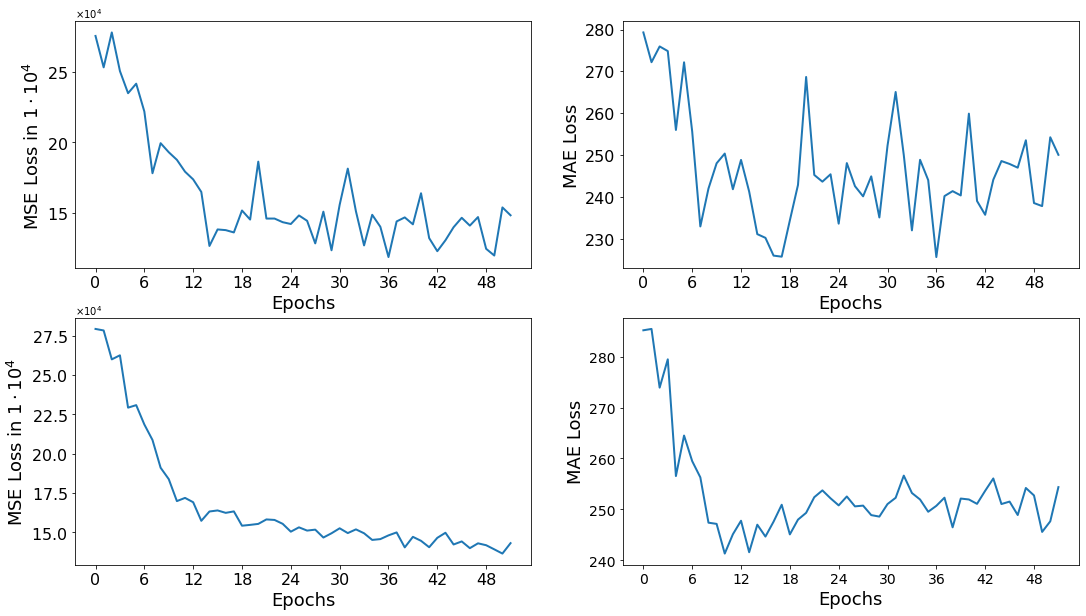

In [163]:
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(18, 10))
label_s=16
font_s=18
ax1.plot(np.arange(len(loss_hist_downstream)), loss_hist_downstream, linewidth=2)
ax1.set_xlabel('Epochs', fontsize=font_s)
ax1.set_ylabel('MSE Loss in $1 \cdot 10^4$', fontsize=font_s)
ax1.tick_params(axis='both', which='major', labelsize=label_s)
ax1.ticklabel_format(axis='y', style='sci', scilimits=(4,4), useOffset=True, useMathText=True)
ax1.xaxis.set_major_locator(MaxNLocator(integer=True))
ax2.plot(np.arange(len(second_metric_hist_downstream)), second_metric_hist_downstream, linewidth=2)
ax2.set_xlabel('Epochs', fontsize=font_s)
ax2.set_ylabel('MAE Loss', fontsize=font_s)
ax2.tick_params(axis='both', which='major', labelsize=16)
ax2.xaxis.set_major_locator(MaxNLocator(integer=True))
ax3.plot(np.arange(len(downstream_val_mse)), downstream_val_mse, linewidth=2)
ax3.set_xlabel('Epochs', fontsize=font_s)
ax3.set_ylabel('MSE Loss in $1 \cdot 10^4$', fontsize=font_s)
ax3.tick_params(axis='both', which='major', labelsize=label_s)
ax3.ticklabel_format(axis='y', style='sci', scilimits=(4,4), useOffset=True, useMathText=True)
ax3.xaxis.set_major_locator(MaxNLocator(integer=True))
ax4.plot(np.arange(len(downstream_val_mae)), downstream_val_mae, linewidth=2)
ax4.set_xlabel('Epochs', fontsize=font_s)
ax4.set_ylabel('MAE Loss', fontsize=font_s)
ax4.tick_params(axis='both', which='major', labelsize=14)
ax4.xaxis.set_major_locator(MaxNLocator(integer=True))
#fig.suptitle('Aliveness estimation training metrics', fontsize=16)
plt.show()

### Circadian

In [164]:
downstream_model = CircadianEstimator(64, 1).to(DEVICE)
downstream_optimizer = torch.optim.Adam(downstream_model.parameters())
downstream_loss = nn.MSELoss()

In [165]:
loss_hist_downstream = []
second_metric_hist_downstream = []

downstream_val_mse = []
downstream_val_mae = []
downstream_val_r2 = []
best = 99999999999999
checkpoint_name = 'ds_checkpoint_circadian_cembedxl'

In [166]:
if False: # faster than commenting out - switch to True to load
# if True:
    loaded_state = load_model(downstream_model, downstream_optimizer, CHECKPOINT_PATH_DOWNSTREAM + checkpoint_name)
    loss_hist_downstream = loaded_state['loss']
    second_metric_hist_downstream = loaded_state['metrics'][0]
    best = loaded_state['metrics'][1][0]
    downstream_val_mse = loaded_state['metrics'][2]
    downstream_val_mae = loaded_state['metrics'][3]
    downstream_val_r2 = loaded_state['metrics'][4]
    del loaded_state

In [45]:
for epoch in range(10):
    l, a = train_estimator(model, downstream_model, 'circadian', downstream_optimizer, downstream_loss, epoch, train_loader, 64)
    loss_hist_downstream.append(l)
    second_metric_hist_downstream.append(a)
    
    mse, mae, r2 = validate(model, downstream_model, 'circadian', test_loader, 64)
    downstream_val_mse.append(mse)
    downstream_val_mae.append(mae)
    downstream_val_r2.append(r2)
    print('val: \tMAE: {:.2f}\tMSE: {:.6f}\tR2: {:.6f}'.format(mae, mse, r2))
    
    # checkpoint
    if mse < best:
        best = mse
        save_model(downstream_model, downstream_optimizer, loss_hist_downstream, 
                   [second_metric_hist_downstream, [best], downstream_val_mse, downstream_val_mae, downstream_val_r2],
                   CHECKPOINT_PATH_DOWNSTREAM + checkpoint_name)

Epoch: 0	MAE: 0.03	MSE: 0.001883
val: 	MAE: 0.04	MSE: 0.003096	R2: 0.299243
Epoch: 1	MAE: 0.04	MSE: 0.003218
val: 	MAE: 0.04	MSE: 0.003501	R2: 0.201665
Epoch: 2	MAE: 0.03	MSE: 0.001699
val: 	MAE: 0.04	MSE: 0.003780	R2: 0.145374
Epoch: 3	MAE: 0.05	MSE: 0.007759
val: 	MAE: 0.03	MSE: 0.003016	R2: 0.321004
Epoch: 4	MAE: 0.04	MSE: 0.004435
val: 	MAE: 0.04	MSE: 0.003258	R2: 0.269573
Epoch: 5	MAE: 0.03	MSE: 0.001591
val: 	MAE: 0.04	MSE: 0.002945	R2: 0.324408
Epoch: 6	MAE: 0.04	MSE: 0.004409
val: 	MAE: 0.04	MSE: 0.002980	R2: 0.322093
Epoch: 7	MAE: 0.04	MSE: 0.001889
val: 	MAE: 0.04	MSE: 0.003212	R2: 0.292581
Epoch: 8	MAE: 0.03	MSE: 0.001260
val: 	MAE: 0.03	MSE: 0.003043	R2: 0.298140
Epoch: 9	MAE: 0.03	MSE: 0.002163
val: 	MAE: 0.04	MSE: 0.002990	R2: 0.337557


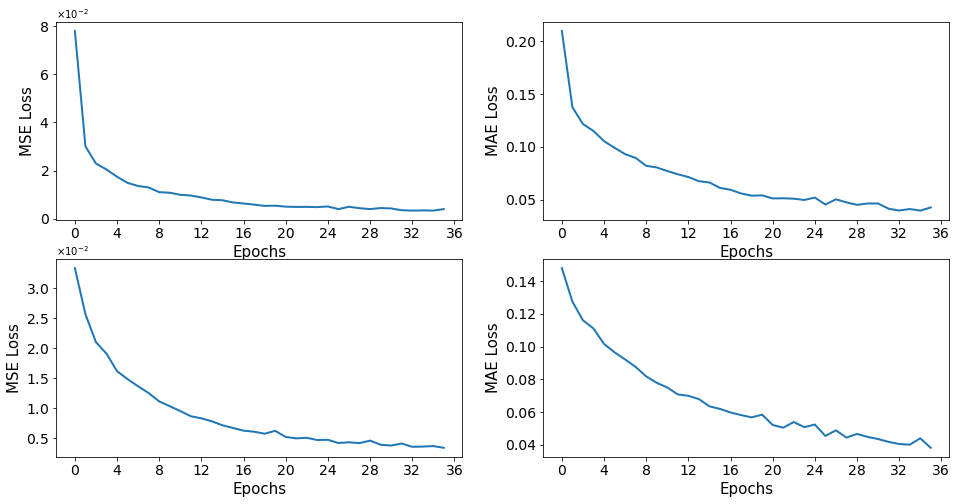

In [167]:
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(16, 8))
ax1.plot(np.arange(len(loss_hist_downstream)), loss_hist_downstream, linewidth=2)
ax1.set_xlabel('Epochs', fontsize=15)
ax1.set_ylabel('MSE Loss', fontsize=15)
ax1.tick_params(axis='both', which='major', labelsize=14)
ax1.ticklabel_format(axis='y', style='sci', scilimits=(0,0), useOffset=True, useMathText=True)
ax1.xaxis.set_major_locator(MaxNLocator(integer=True))
ax2.plot(np.arange(len(second_metric_hist_downstream)), second_metric_hist_downstream, linewidth=2)
ax2.set_xlabel('Epochs', fontsize=15)
ax2.set_ylabel('MAE Loss', fontsize=15)
ax2.tick_params(axis='both', which='major', labelsize=14)
ax2.xaxis.set_major_locator(MaxNLocator(integer=True))
ax3.plot(np.arange(len(downstream_val_mse)), downstream_val_mse, linewidth=2)
ax3.set_xlabel('Epochs', fontsize=15)
ax3.set_ylabel('MSE Loss', fontsize=15)
ax3.tick_params(axis='both', which='major', labelsize=14)
ax3.ticklabel_format(axis='y', style='sci', scilimits=(0,0), useOffset=True, useMathText=True)
ax3.xaxis.set_major_locator(MaxNLocator(integer=True))
ax4.plot(np.arange(len(downstream_val_mae)), downstream_val_mae, linewidth=2)
ax4.set_xlabel('Epochs', fontsize=15)
ax4.set_ylabel('MAE Loss', fontsize=15)
ax4.tick_params(axis='both', which='major', labelsize=14)
ax4.xaxis.set_major_locator(MaxNLocator(integer=True))
#fig.suptitle('Circadian estimation training metrics', fontsize=16)
plt.show()

# Evaluation

In [218]:
validate(model, downstream_model, 'lifespan', test_loader)

(211856.99906191442, 267.2218940078569, -0.16695934342552476)

In [143]:
validate(model, downstream_model, 'circadian', test_loader)

(0.005531955018373718, 0.03355639705082996, -0.2426577293260952)

The mean life time of an individual is 18 days. Let's compare our validation to this baseline as well as to always predicting zero to get a feeling if our prediction is any good.

## Embeddings

What did our CNN learn? How do the weights look?

In [339]:
# model = CPC(N_STEPS, BATCH_SIZE, hidden_size=64, context_size=128)
# load_model(model, optimizer, CHECKPOINT_PATH + 'cpc_checkpoint_nbh_64_128.pt')
model.to('cpu')
downstream_model.to('cpu')
embeddings = model.g_enc.detach().numpy()

print(embeddings.shape)

(35, 2443, 64)


<AxesSubplot:>

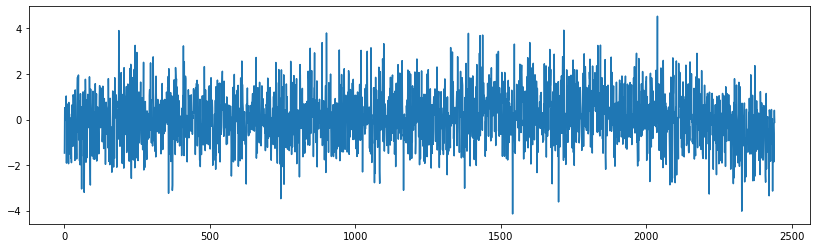

In [125]:
pd.DataFrame(embeddings[0,:,0]).plot(figsize=(14,4), legend=False)

In [126]:
embeddings[:,0].shape

(35, 64)

In [127]:
vmin_total = embeddings.min().item()
vmax_total = embeddings.max().item()

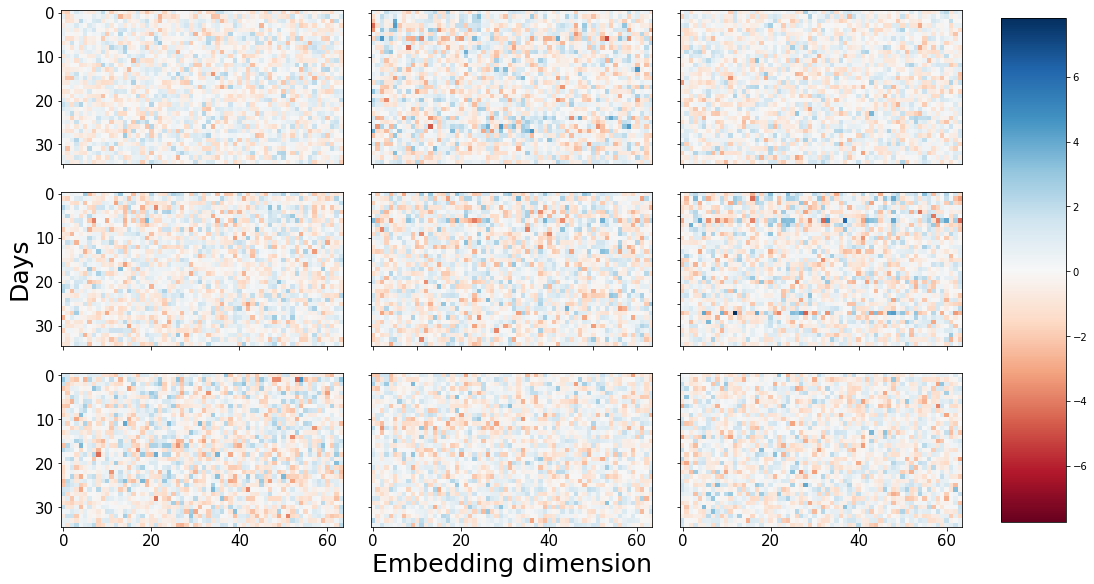

In [159]:
# embeddings for 1 individual for 35 days
individuals = list(range(0,9))
fig, axes = plt.subplots(3, 3, figsize=(18, 10))
# vmin = embeddings[:,individuals].min().item()
# vmax = embeddings[:,individuals].max().item()
vmin = vmin_total
vmax = vmax_total

for row in range(len(axes)):
    for col in range(len(axes)):
        im = axes[row][col].imshow(embeddings[:, individuals[row * 3 + col], :], cmap='RdBu', interpolation='nearest', aspect='equal', vmin=vmin, vmax=vmax)
        axes[row][col].tick_params(labelcolor='none', bottom=True, left=True, labelbottom=False, labelleft=False)

for ax in axes[-1]:
    ax.tick_params(axis='both', bottom=True, labelbottom=True, labelcolor='black', labelsize=15)
for ax in axes[:,0]:
    ax.tick_params(axis='both', left=True, labelleft=True, labelcolor='black', labelsize=15)
axes[-1][1].set_xlabel('Embedding dimension', fontsize=25)
axes[1][0].set_ylabel('Days', fontsize=25)


fig.subplots_adjust(right=0.82)
cbar_ax = fig.add_axes([0.85, 0.15, 0.05, 0.7])
fig.colorbar(im, cax=cbar_ax)
# fig.suptitle('CNN kernel weights heatmap', fontsize=24)

# fig.tight_layout()
plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=.1, hspace=.001)

plt.show()

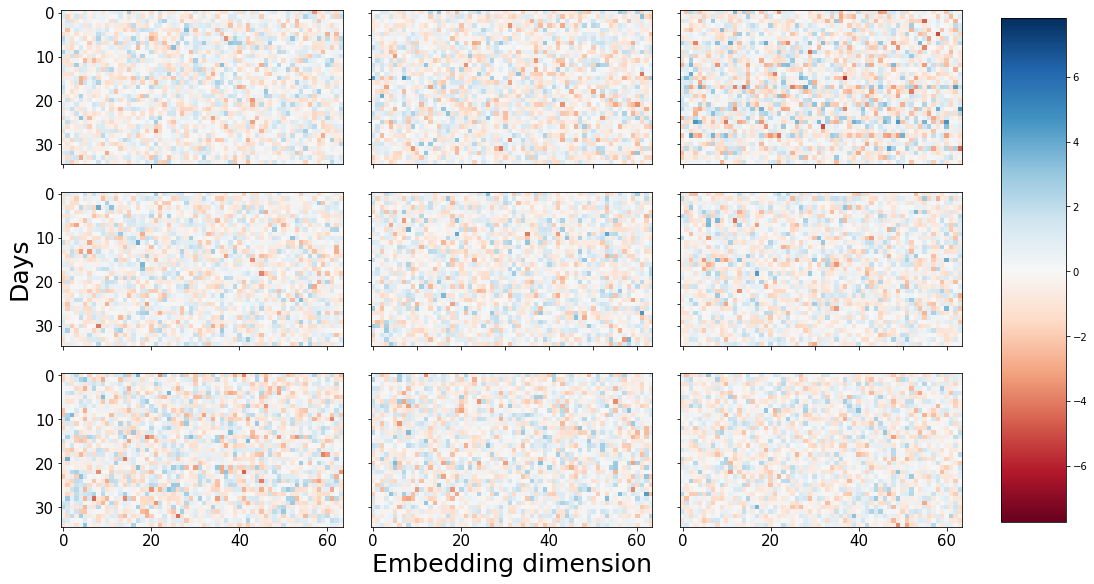

In [161]:
# embeddings for 1 individual for 35 days
individuals = list(range(1000,1009))
fig, axes = plt.subplots(3, 3, figsize=(18, 10))
# vmin = embeddings[:,individuals].min().item()
# vmax = embeddings[:,individuals].max().item()
vmin = vmin_total
vmax = vmax_total

for row in range(len(axes)):
    for col in range(len(axes)):
        im = axes[row][col].imshow(embeddings[:, individuals[row * 3 + col], :], cmap='RdBu', interpolation='nearest', aspect='equal', vmin=vmin, vmax=vmax)
        axes[row][col].tick_params(labelcolor='none', bottom=True, left=True, labelbottom=False, labelleft=False)

for ax in axes[-1]:
    ax.tick_params(axis='both', bottom=True, labelbottom=True, labelcolor='black', labelsize=15)
for ax in axes[:,0]:
    ax.tick_params(axis='both', left=True, labelleft=True, labelcolor='black', labelsize=15)
axes[-1][1].set_xlabel('Embedding dimension', fontsize=25)
axes[1][0].set_ylabel('Days', fontsize=25)


fig.subplots_adjust(right=0.82)
cbar_ax = fig.add_axes([0.85, 0.15, 0.05, 0.7])
fig.colorbar(im, cax=cbar_ax)
# fig.suptitle('CNN kernel weights heatmap', fontsize=24)

# fig.tight_layout()
plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=.1, hspace=.001)

plt.show()

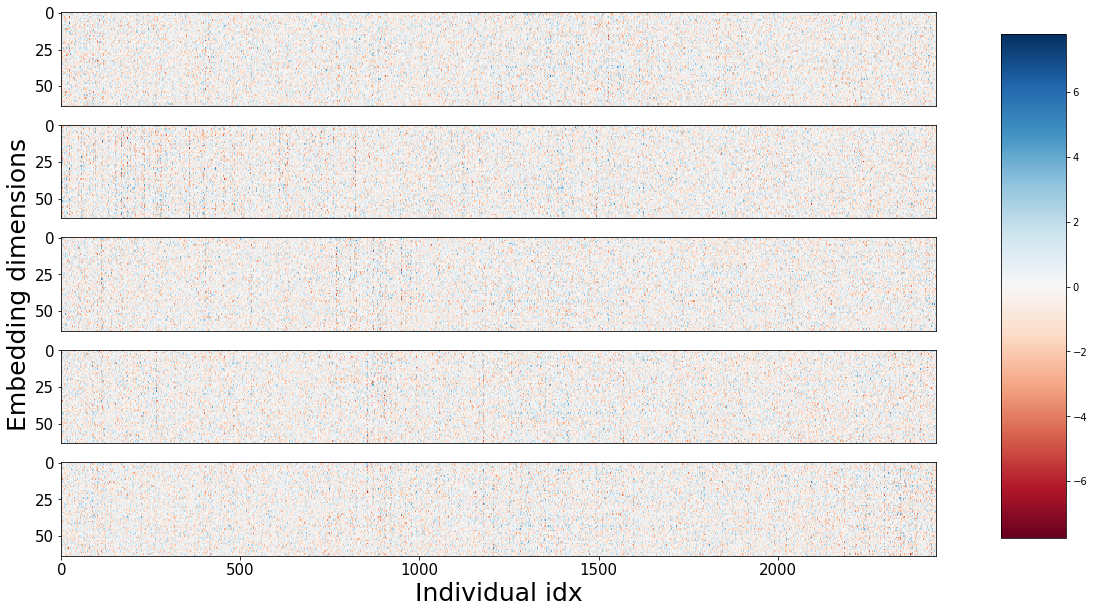

In [149]:
# 35 d
individuals = list(range(5,10))
fig, axes = plt.subplots(len(individuals), 1, figsize=(18, 10))
vmin = vmin_total
vmax = vmax_total
for i in range(len(axes)):
    im = axes[i].imshow(embeddings[individuals[i], :, :].transpose(), cmap='RdBu', interpolation='nearest', aspect='auto', vmin=vmin, vmax=vmax)
    axes[i].tick_params(bottom=False, left=True, labelbottom=False, labelleft=True, labelsize=15)
axes[-1].tick_params(axis='both', bottom=True, labelbottom=True, labelcolor='black')
axes[-1].set_xlabel('Individual idx', fontsize=25)
axes[len(axes) // 2].set_ylabel('Embedding dimensions', fontsize=25)
axes[-1].tick_params(axis='x', which='major', labelsize=15)

fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.85, 0.15, 0.05, 0.7])
fig.colorbar(im, cax=cbar_ax)
# fig.suptitle('CNN kernel weights heatmap', fontsize=24)

plt.show()

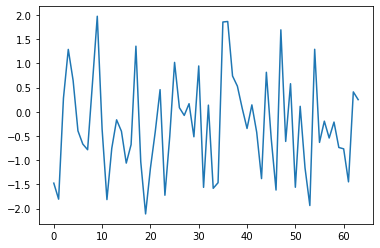

In [151]:
plt.plot(embeddings[0,0,:][..., np.newaxis])

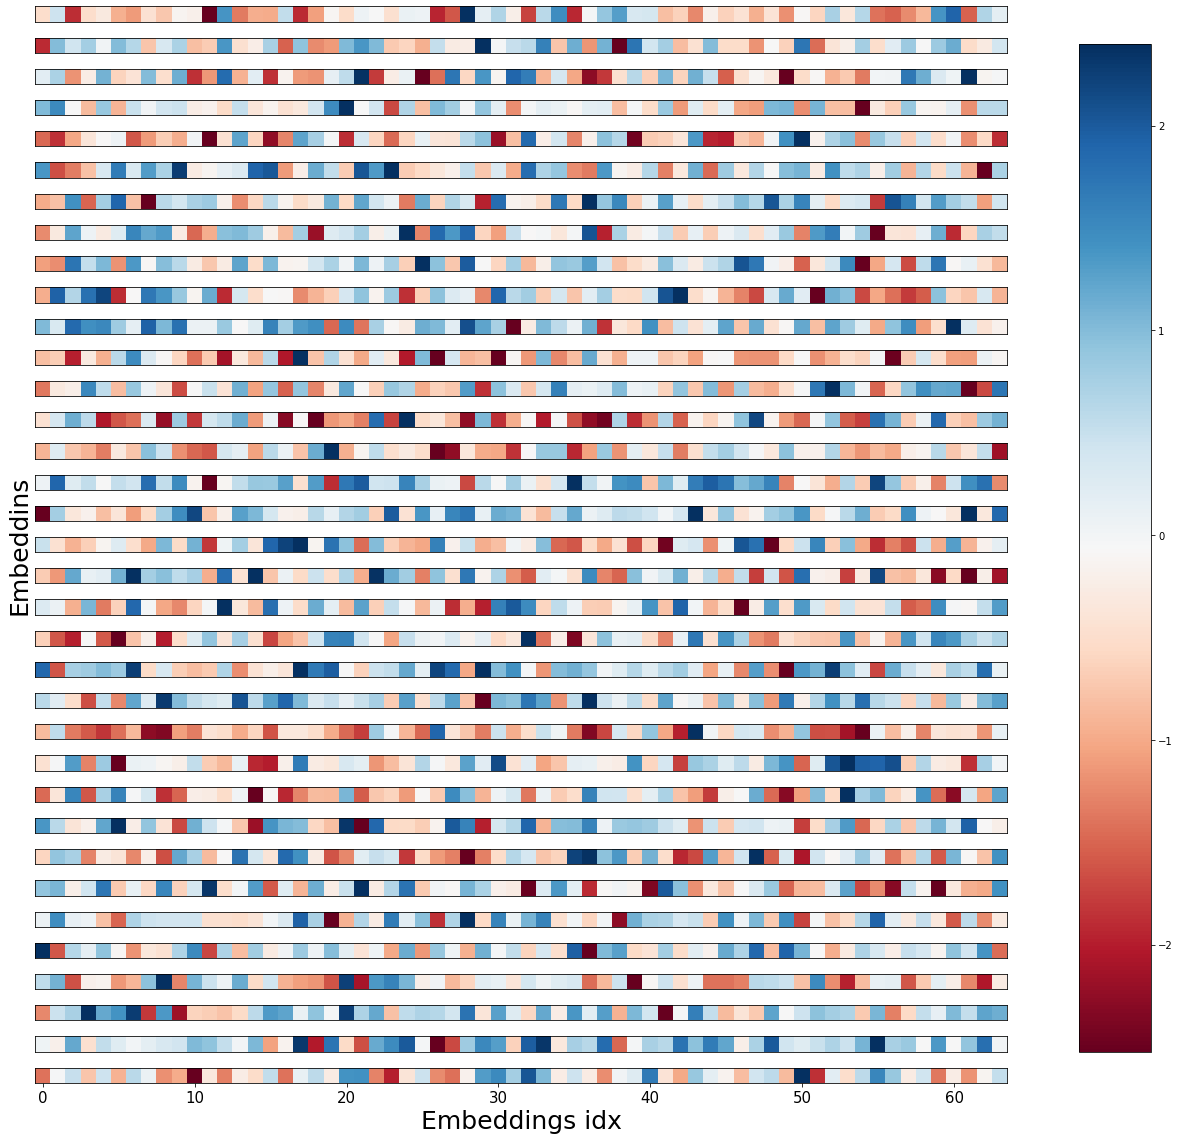

In [153]:
# 1 indv
fig, axes = plt.subplots(35, 1, figsize=(20, 20))
vmin = embeddings.min().item()
vmax = embeddings.max().item()
for i in range(len(axes)):
    im = axes[i].imshow(embeddings[i,2,:][np.newaxis, ...], cmap='RdBu', interpolation='nearest', aspect='equal') #vmin=vmin, vmax=vmax
#     axes[i].plot(embeddings[i,0,:][..., np.newaxis])
    axes[i].tick_params(labelcolor='none', bottom=False, left=False, labelbottom=False, labelleft=False)
axes[-1].tick_params(axis='both', bottom=True, labelbottom=True, labelcolor='black')
axes[-1].set_xlabel('Embeddings idx', fontsize=25)
axes[17].set_ylabel('Embeddins', fontsize=25)
axes[-1].tick_params(axis='x', which='major', labelsize=15)

fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.85, 0.15, 0.05, 0.7])
fig.colorbar(im, cax=cbar_ax)

plt.show()

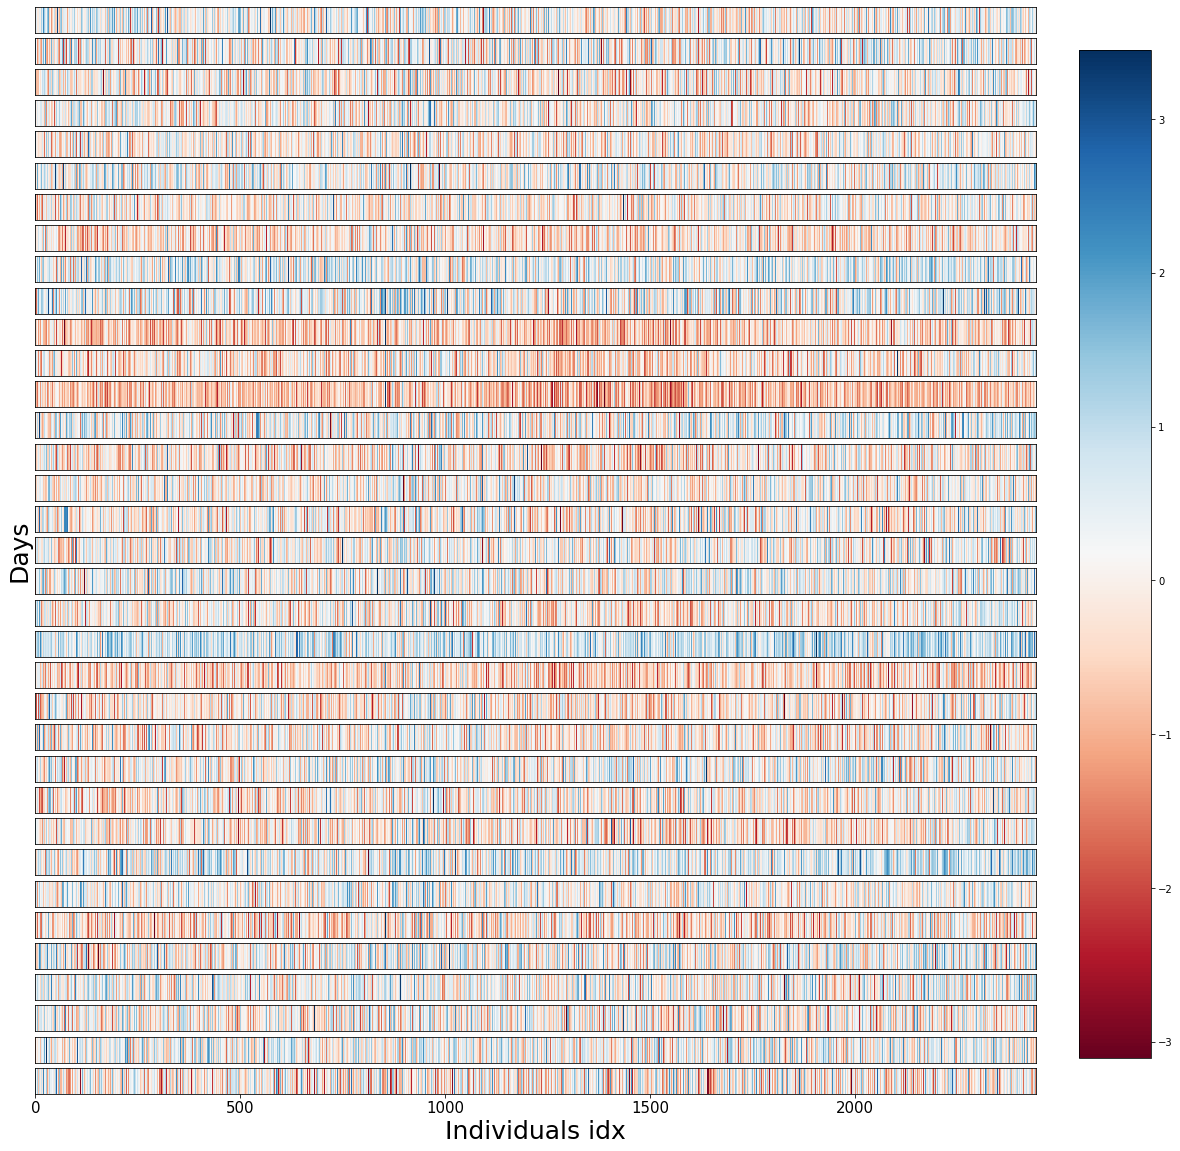

In [165]:
# 1 embed
fig, axes = plt.subplots(35, 1, figsize=(20, 20))
embedding = 2
vmin = embeddings[:,:,embedding].min().item()
vmax = embeddings[:,:,embedding].max().item()
for i in range(len(axes)):
    im = axes[i].imshow(embeddings[i,:,embedding][np.newaxis, ...], cmap='RdBu', interpolation='nearest', aspect='auto') #vmin=vmin, vmax=vmax
#     axes[i].plot(embeddings[i,0,:][..., np.newaxis])
    axes[i].tick_params(labelcolor='none', bottom=False, left=False, labelbottom=False, labelleft=False)
axes[-1].tick_params(axis='both', bottom=True, labelbottom=True, labelcolor='black')
axes[-1].set_xlabel('Individuals idx', fontsize=25)
axes[17].set_ylabel('Days', fontsize=25)
axes[-1].tick_params(axis='x', which='major', labelsize=15)

fig.subplots_adjust(right=0.82)
cbar_ax = fig.add_axes([0.85, 0.15, 0.05, 0.7])
fig.colorbar(im, cax=cbar_ax)

plt.show()

In [172]:
embeddings[0,:,:].mean(axis=0)[np.newaxis, ...].shape

(1, 64)

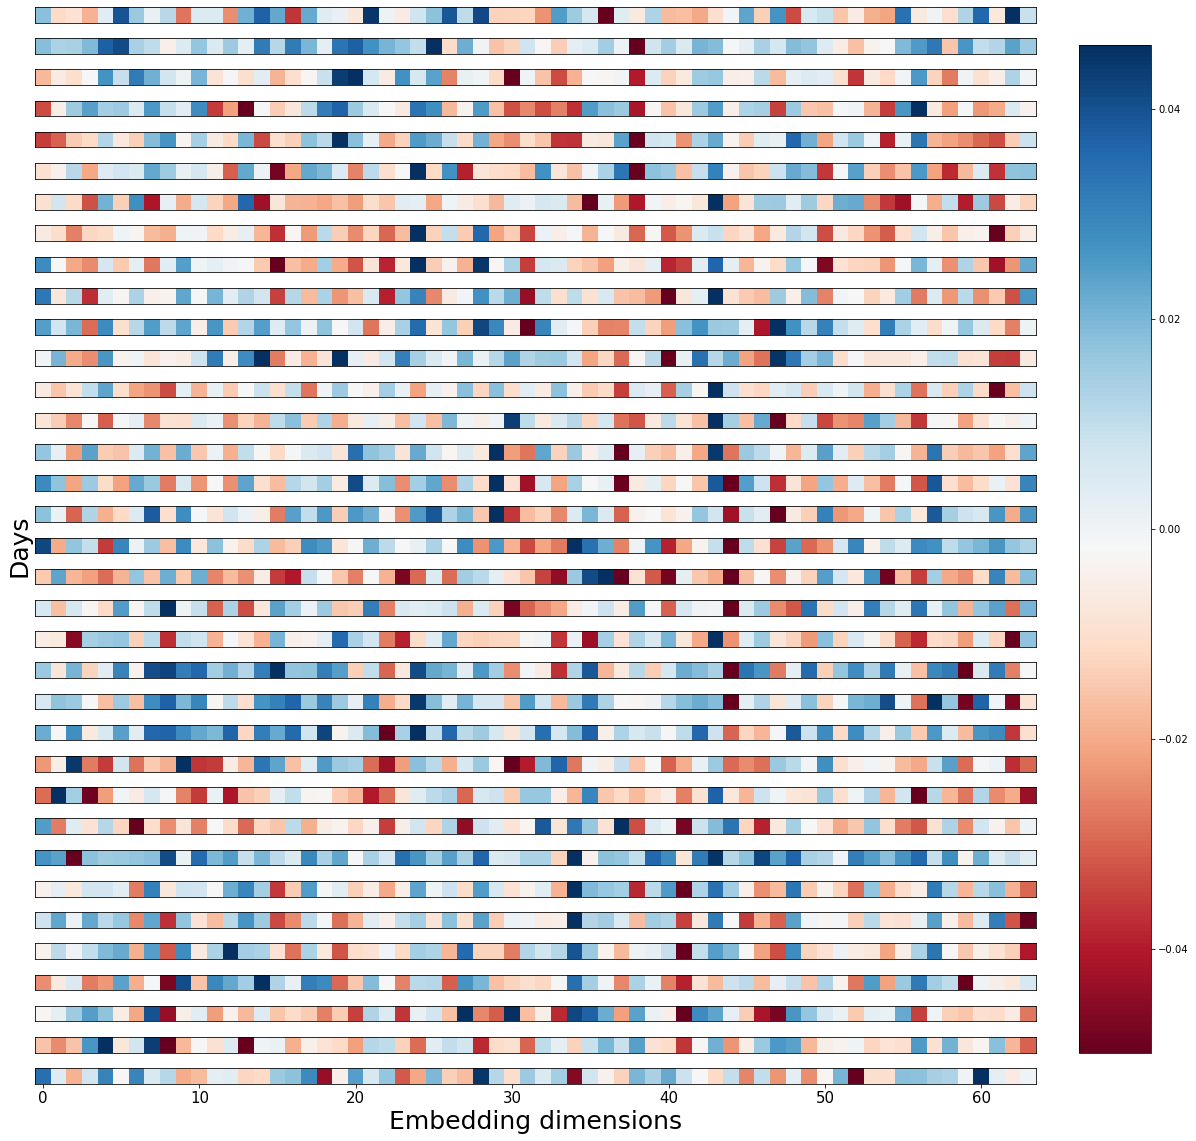

In [179]:
# mean over ind
fig, axes = plt.subplots(35, 1, figsize=(20, 20))
vmin = vmin_total
vmax = vmax_total
for i in range(len(axes)):
    im = axes[i].imshow(embeddings[i,:,:].mean(axis=0)[np.newaxis, ...], cmap='RdBu', interpolation='nearest', aspect='equal') #vmin=vmin, vmax=vmax
#     axes[i].plot(embeddings[i,0,:][..., np.newaxis])
    axes[i].tick_params(labelcolor='none', bottom=False, left=False, labelbottom=False, labelleft=False)
axes[-1].tick_params(axis='both', bottom=True, labelbottom=True, labelcolor='black')
axes[-1].set_xlabel('Embedding dimensions', fontsize=25)
axes[len(axes) // 2].set_ylabel('Days', fontsize=25)
axes[-1].tick_params(axis='x', which='major', labelsize=15)

fig.subplots_adjust(right=0.82)
cbar_ax = fig.add_axes([0.85, 0.15, 0.05, 0.7])
fig.colorbar(im, cax=cbar_ax)

plt.show()

## combined plot

In [376]:
# for one individual let's show the actual embeddings
# z = (x * self.g_enc[:, ]).mean(dim=2)
model.to('cpu')
model.eval()
z = None
ys = None
for batch_idx, (x, y) in enumerate(full_loader):
    x = x.unsqueeze(1).permute((0, 2, 3, 1))
    z = (x * model.g_enc[:, ]).mean(dim=2).detach()
    ys = y
    break

In [ ]:
ys

In [ ]:
(ys['lifespan'][0].reshape(56, 48)[:,0] + 1) / 48

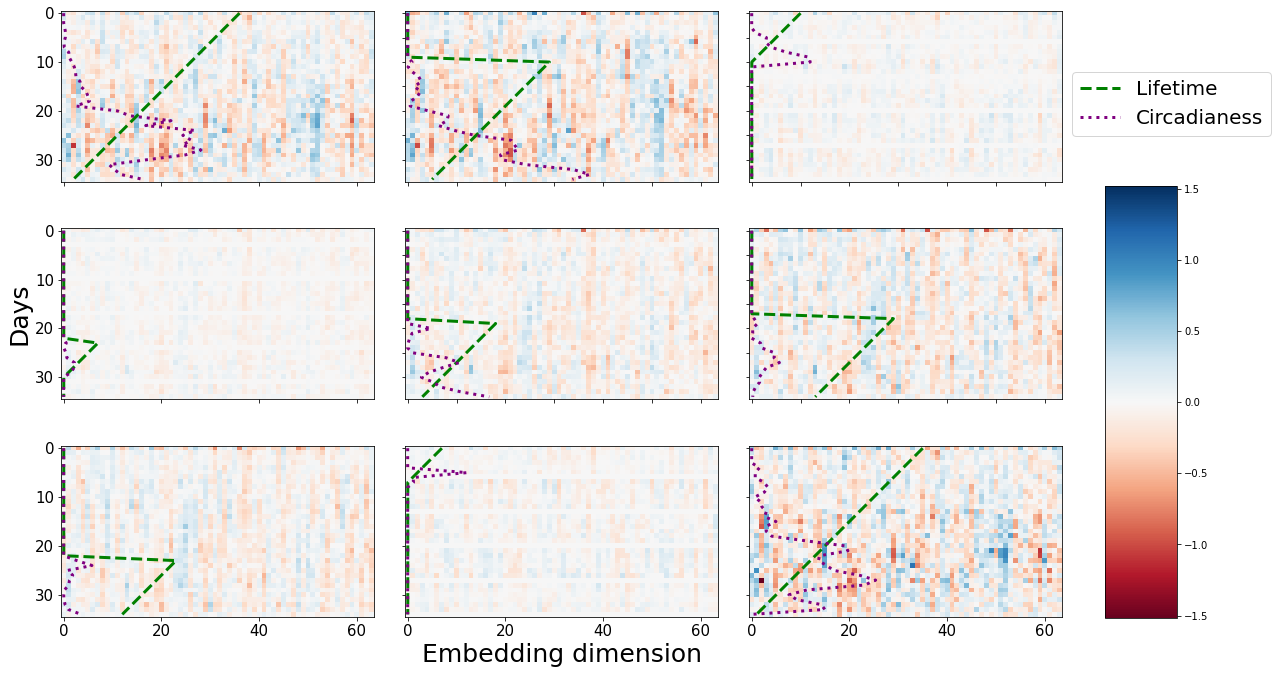

In [377]:
fig, axes = plt.subplots(3, 3, figsize=(20, 12))

min_ = z[:9].min()
max_ = z[:9].max()
# symmetric
vmin = 0 - np.max(np.abs((min_, max_)))
vmax = 0 + np.max(np.abs((min_, max_)))

for row in range(len(axes)):
    for col in range(len(axes)):
        ax = axes[row][col]
        idx = row * 3 + col
        im = ax.imshow(z[idx], cmap='RdBu', interpolation='nearest', aspect='equal', vmin=vmin, vmax=vmax)
        ax.tick_params(labelcolor='none', bottom=True, left=True, labelbottom=False, labelleft=False)
        lifespan = ((ys['lifespan'][idx].reshape(56, 48)[:,0] + 1) / 48)[:35]
        life_plt = ax.plot(lifespan, np.arange(35), '--', color='green', linewidth=3, label='Lifetime')
#         ax2 = ax.twiny()
#         ax2.tick_params(axis='both', bottom=False, left=False, top=False, labelbottom=False, labelleft=False, labeltop=False)
        circ = (ys['circadian'][idx].reshape(56, 48)[:,0] * 100)[:35] # x100 to make it visible
        circ_plt = ax.plot(circ, np.arange(35), ':', color='purple', linewidth=3, label='Circadianess')
        if idx == 8:
            ax.legend(fontsize=20, loc='center left', bbox_to_anchor=(1, 3))
        
for ax in axes[-1]:
    ax.tick_params(axis='both', bottom=True, labelbottom=True, labelcolor='black', labelsize=15)
for ax in axes[:,0]:
    ax.tick_params(axis='both', left=True, labelleft=True, labelcolor='black', labelsize=15)
axes[-1][1].set_xlabel('Embedding dimension', fontsize=25)
axes[1][0].set_ylabel('Days', fontsize=25)

fig.subplots_adjust(right=0.82)
# cbar_ax = fig.add_axes([0.85, 0.15, 0.05, 0.7])
cbar_ax = fig.add_axes([0.85, 0.15, 0.05, 0.5])
fig.colorbar(im, cax=cbar_ax)

plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=.1, hspace=.001)
plt.show()

In [210]:
ds_weights = downstream_model.linear.weight.detach().t()
sorted_ds_weights, sorted_ds_weights_idx = torch.sort(ds_weights, dim=0)
sorted_ds_weights_idx = sorted_ds_weights_idx.squeeze()

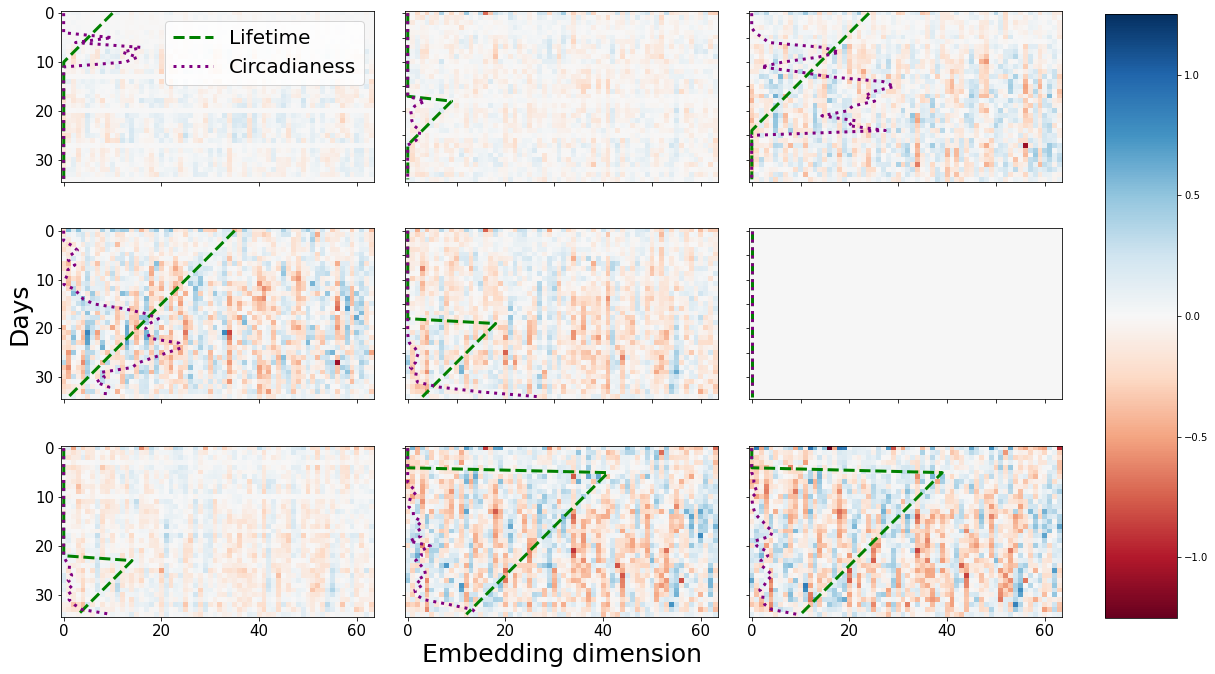

In [351]:
# let's sort embedding dims by the downstream coefficients

fig, axes = plt.subplots(3, 3, figsize=(20, 12))

min_ = z[:9].min()
max_ = z[:9].max()
# symmetric
vmin = 0 - np.max(np.abs((min_, max_)))
vmax = 0 + np.max(np.abs((min_, max_)))

for row in range(len(axes)):
    for col in range(len(axes)):
        ax = axes[row][col]
        idx = row * 3 + col
        im = ax.imshow(z[idx][:, sorted_ds_weights_idx], cmap='RdBu', interpolation='nearest', aspect='equal', vmin=vmin, vmax=vmax)
        ax.tick_params(labelcolor='none', bottom=True, left=True, labelbottom=False, labelleft=False)
        lifespan = ((ys['lifespan'][idx].reshape(56, 48)[:,0] + 1) / 48)[:35]
        life_plt = ax.plot(lifespan, np.arange(35), '--', color='green', linewidth=3, label='Lifetime')
#         ax2 = ax.twiny()
#         ax2.tick_params(axis='both', bottom=False, left=False, top=False, labelbottom=False, labelleft=False, labeltop=False)
        circ = (ys['circadian'][idx].reshape(56, 48)[:,0] * 100)[:35] # x100 to make it visible
        circ_plt = ax.plot(circ, np.arange(35), ':', color='purple', linewidth=3, label='Circadianess')
        if idx == 0:
            ax.legend(fontsize=20)
        
for ax in axes[-1]:
    ax.tick_params(axis='both', bottom=True, labelbottom=True, labelcolor='black', labelsize=15)
for ax in axes[:,0]:
    ax.tick_params(axis='both', left=True, labelleft=True, labelcolor='black', labelsize=15)
axes[-1][1].set_xlabel('Embedding dimension', fontsize=25)
axes[1][0].set_ylabel('Days', fontsize=25)

fig.subplots_adjust(right=0.82)
cbar_ax = fig.add_axes([0.85, 0.15, 0.05, 0.7])
fig.colorbar(im, cax=cbar_ax)

plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=.1, hspace=.001)
plt.show()

now ordered

In [353]:
bee_idx = [5, 8, 12, 1556, 7, 1592, 2024, 2025, 2026]

x = torch.zeros((len(bee_idx), 35, 2443))
y = {
    'lifespan': torch.zeros((len(bee_idx), 2688)),
    'circadian': torch.zeros((len(bee_idx), 2688))
}
for i in range(len(bee_idx)):
    idx = bee_idx[i]
    data = bn16_data[idx]
    x[i] = data[0]
    y['lifespan'][i] = torch.tensor(data[1]['lifespan'])
    y['circadian'][i] = torch.tensor(data[1]['circadian'])
    
x = x.unsqueeze(1).permute((0, 2, 3, 1))
z = (x * model.g_enc[:, ]).mean(dim=2).detach()
ys = y

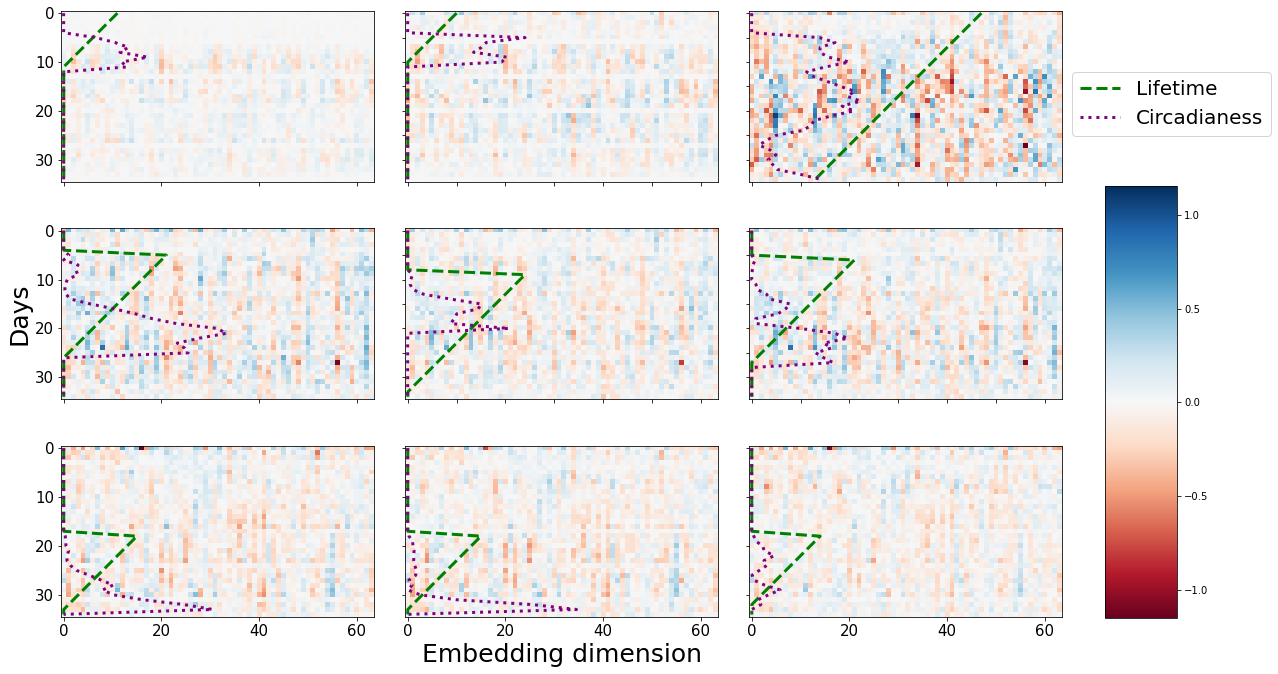

In [375]:
# let's sort embedding dims by the downstream coefficients

fig, axes = plt.subplots(3, 3, figsize=(20, 12))

min_ = z[:9].min()
max_ = z[:9].max()
# symmetric
vmin = 0 - np.max(np.abs((min_, max_)))
vmax = 0 + np.max(np.abs((min_, max_)))

for row in range(len(axes)):
    for col in range(len(axes)):
        ax = axes[row][col]
        idx = row * 3 + col
        # non-sorted
#         im = ax.imshow(z[idx], cmap='RdBu', interpolation='nearest', aspect='equal', vmin=vmin, vmax=vmax)
        # sorted
        im = ax.imshow(z[idx][:, sorted_ds_weights_idx], cmap='RdBu', interpolation='nearest', aspect='equal', vmin=vmin, vmax=vmax)
        ax.tick_params(labelcolor='none', bottom=True, left=True, labelbottom=False, labelleft=False)
        lifespan = ((ys['lifespan'][idx].reshape(56, 48)[:,0] + 1) / 48)[:35]
        life_plt = ax.plot(lifespan, np.arange(35), '--', color='green', linewidth=3, label='Lifetime')
#         ax2 = ax.twiny()
#         ax2.tick_params(axis='both', bottom=False, left=False, top=False, labelbottom=False, labelleft=False, labeltop=False)
        circ = (ys['circadian'][idx].reshape(56, 48)[:,0] * 100)[:35] # x100 to make it visible
        circ_plt = ax.plot(circ, np.arange(35), ':', color='purple', linewidth=3, label='Circadianess')
        if idx == 8:
            ax.legend(fontsize=20, loc='center left', bbox_to_anchor=(1, 3))
        
for ax in axes[-1]:
    ax.tick_params(axis='both', bottom=True, labelbottom=True, labelcolor='black', labelsize=15)
for ax in axes[:,0]:
    ax.tick_params(axis='both', left=True, labelleft=True, labelcolor='black', labelsize=15)
axes[-1][1].set_xlabel('Embedding dimension', fontsize=25)
axes[1][0].set_ylabel('Days', fontsize=25)

fig.subplots_adjust(right=0.82)
# cbar_ax = fig.add_axes([0.85, 0.15, 0.05, 0.7])
# fig.colorbar(im, cax=cbar_ax)
cbar_ax = fig.add_axes([0.85, 0.15, 0.05, 0.5])
fig.colorbar(im, cax=cbar_ax)

plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=.1, hspace=.001)
plt.show()

In [314]:
model.to(DEVICE)
downstream_model.to(DEVICE)

CircadianEstimator(
  (linear): Linear(in_features=64, out_features=1, bias=True)
)

In [133]:
gc.collect()
torch.cuda.empty_cache()
# torch.cuda.memory_summary(DEVICE)
int(torch.cuda.memory_allocated(DEVICE) / 1000 / 1000)

66

In [51]:
a = torch.ones((64, 35, 2443, 1)) * torch.ones((35, 2443, 8))
a.shape

torch.Size([64, 35, 2443, 8])